<a href="https://colab.research.google.com/github/Meghdad-DTU/BIXI-Demand-Prediction/blob/main/Bixi_bike_sharing_prediction_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#read data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from google.colab import drive

In [2]:
#######################################################################
# the source of randomness can be fixed to make results reproducible
from numpy.random import seed
import itertools
#######################################################################
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.layers import Input, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization, concatenate, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping

#######################################################################
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
##########################################################################
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# GPU type
"from tensorflow.python.client import device_lib"
"device_lib.list_local_devices()"
# RAM info
"!cat /proc/meminfo"
# CPU info
"!cat /proc/cpuinfo"

'!cat /proc/cpuinfo'

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Ingestion

In [6]:
path = "/content/drive/My Drive/bixi_data/"

bixi_dat = pd.read_csv(path+"final_bixi_with_wrt_cal_15min.csv", parse_dates = ['index'],  index_col=0)
bixi_dat.rename(columns={'index':'timestamp'}, inplace=True)
bixi_dat.head()

,timestamp,com1,com2,com3,com4,com5,com6,business_day,tod_afternoon,tod_afternoon_rush,tod_evening,tod_lunch_time,tod_morning,tod_morning_rush,tod_night,Temperature,Precipitation,Wind Speed,Relative Humidity
0,2017-04-15 00:00:00,8.0,5.0,4.0,11.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.3,0.0,9.0,57.0
1,2017-04-15 00:15:00,1.0,5.0,3.0,8.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.3,0.0,9.0,57.0
2,2017-04-15 00:30:00,2.0,5.0,6.0,9.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.3,0.0,9.0,57.0
3,2017-04-15 00:45:00,3.0,3.0,4.0,2.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.3,0.0,9.0,57.0
4,2017-04-15 01:00:00,7.0,4.0,3.0,6.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.3,0.0,7.0,58.0


In [7]:
# Bike-sharing demand for each community from 1 to 6
demand_features = ['com1', 'com2', 'com3', 'com4', 'com5', 'com6']
# Weather-calender variables
extra_features = ['business_day', 'tod_afternoon', 'tod_afternoon_rush','tod_evening','tod_lunch_time','tod_morning','tod_morning_rush','tod_night','Temperature','Precipitation', 'Wind Speed', 'Relative Humidity']

# Bike sharing demand for each community over time
bixi_demand = bixi_dat[demand_features].values
print(bixi_demand.shape)
# Weather-calender variables over time
weather_calender = bixi_dat[extra_features].values
print(weather_calender.shape)

(81309, 6)
(81309, 12)


### Data Preperation

In [8]:

def split_sequence(sequence, lag):
    '''
    This function splits a given univariate sequence into
    multiple samples where each sample has a specified number
    of time steps and the output is a single time step.
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + lag

    # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def convert_to_supervised(lag, dat1, dat2=None):
    '''
    This function takes a 2D sequennce, scales the array and splits
    a given multivariate sequence into multiple samples where each sample has a specified number
    of time steps. It returns multiple time steps as well as the scaler.
    param dat1: Bike sharing demand for each community over time
    param dat2: Weather-calender variables over time
    '''
    _, start_test = train_val_test(print_info=False)
    if dat2 is None:
        # scale data to [-1, 1]
        scaler = MinMaxScaler(feature_range=(-1, 1))
        dat1_train, dat1_test = train_test_split(X=dat1, start_test = start_test)
        scaled_train = scaler.fit_transform(dat1_train)
        scaled_test = scaler.transform(dat1_test)
        scaled_dat = np.vstack([scaled_train, scaled_test])
        m, n = scaled_dat.shape
        # e.g., if lag = 7, BIXI demand of past 7*15 minutes
        scaled_X = np.zeros((m-lag,lag, n))
        scaled_y = np.zeros((m-lag,n))

        for i in range(0,n):
            X, y = split_sequence(scaled_dat[:,i],lag)
            scaled_X[:,:,i] = X
            scaled_y[:,i] = y
        return scaler, scaled_X, scaled_y

    else:
        # scaler for bixi demand data
        scaler = MinMaxScaler(feature_range=(-1, 1))
        dat1_train, dat1_test = train_test_split(X=dat1, start_test = start_test)
        scaled_train1 = scaler.fit_transform(dat1_train)
        scaled_test1 = scaler.transform(dat1_test)
        # scaler2 for stacked weather-calender and extra demand features
        scaler2 = MinMaxScaler(feature_range=(-1, 1))
        dat2_train, dat2_test = train_test_split(X=dat2, start_test = start_test)
        scaled_train2 = scaler2.fit_transform(dat2_train)
        scaled_test2 = scaler2.transform(dat2_test)

        scaled_dat1 = np.vstack([scaled_train1, scaled_test1])
        scaled_dat2 = np.vstack([scaled_train2, scaled_test2])

        m, n = scaled_dat1.shape
        _, k = scaled_dat2.shape

        # Bixi demand of the past lag days
        scaled_X = np.zeros((m-lag, lag+k, n))
        scaled_y = np.zeros((m-lag,n))

        for i in range(0,n):
            X,y = split_sequence(scaled_dat1[:,i],lag)
            X = np.hstack([X,scaled_dat2[lag:,:]])
            scaled_X[:,:,i] = X
            scaled_y[:,i] = y
        return scaler, scaler2, scaled_X, scaled_y

def invert_scale(scaler, y):
    '''
    Inverse scaling for a predicted value
    '''
    return scaler.inverse_transform(y)

def train_val_test(dat=bixi_dat, train_end_date='2020-04-15 10:45:00', val_end_date='2020-07-15 18:15:00', print_info=True):
    '''
    Important: determine train, test and validation based on Covid outbreak
    param train_end (timstamp): end of training set
    param val_end (timestamp): end of validation set
    '''
    assert train_end_date < val_end_date, "WARNING: validation date must be later than training date."
    train = dat.timestamp[dat.timestamp == train_end_date].index.values[0]
    validation = dat.timestamp[dat.timestamp == val_end_date].index.values[0]
    train_val_ratio = validation/train
    # test set preparation
    start_test =  len(dat) - validation

    if print_info:
      print(f"Train set starts at {dat.loc[0,'timestamp']} and ends at {dat.loc[train,'timestamp']}")
      print(f"Validation set starts at {dat.loc[train,'timestamp']} and ends at {dat.loc[validation,'timestamp']}")
      print(f"Test set starts at {dat.loc[validation,'timestamp']} and ends at {dat.loc[len(dat),'timestamp']}")
      print(f'\nTrain set size: {train}\nValidation set size: {validation - train}\nTest set size: {start_test}\n')
    return train_val_ratio, start_test

def train_test_split(X, y = None, start_test = None, ratio= 0.3):
    '''
    Train test split for times-series data
    '''
    if start_test is None:
        lenght,_ = X.shape
        start_test = int(ratio*lenght)
    X_train, X_test = X[0:-start_test], X[-start_test:]


    if y is None:
      return  X_train, X_test
    else:
      y_train, y_test = y[:-start_test], y[-start_test:]
      return X_train, X_test, y_train, y_test

def model_dim(X):
    """
    Deep learning architucture size for input, fearures and output
    """
    n_features, n_steps_out = X.shape[2], X.shape[2]
    n_steps_in = X.shape[1]
    return n_steps_in, n_features, n_steps_out


def integer_factor(n):
    """ calculate integer factorization of n
    and then returns them as two multiplications"""
    def is_prime(n):
        if n == 1:
            return False
        if n % 2 == 0:
            return False
        i = 3
        while i * i <= n:
            if n % i == 0:
                return False
            i += 2
        return True

    def prime_factors(n):
        prime_factor_list = []
        prime_factor_list.append(1)
        for i in itertools.chain([2], itertools.count(3, 2)):
            if n <= 1:
                break
            while n % i == 0:
                n //= i
                prime_factor_list.append(i)
        return prime_factor_list

    lst = prime_factors(n)
    lng = len(lst)
    half= int(np.round(lng/2+1))
    list1, list2 = lst[0:half], lst[half:]
    n_steps, n_sequence = np.prod(list1), np.prod(list2)
    return n_steps, n_sequence


def demand_extra_feature(dat):
    '''
    This function adds engineered features to demand dataset.
    '''
    Mean = dat.mean(1)
    Max = dat.max(1)
    Min = dat.min(1)
    Q25 = np.quantile(dat,0.25,axis=1)
    Q50 = np.quantile(dat,0.50,axis=1)
    Q75 = np.quantile(dat,0.75,axis=1)
    Std = dat.std(axis=1)
    return np.vstack([Mean,Max,Min,Q25,Q50,Q75,Std]).T

### Deep Learning Models Archituctures

In [9]:
## LSTM family
def one_LSTM(n_steps_in, n_features, n_steps_out, lstm_size, dropout, dc_size):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_steps_in, n_features)))
    model.add(LSTM(lstm_size, dropout=dropout, recurrent_dropout=0, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(dc_size))
    model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['MSE'])
    return model

def one_biLSTM(n_steps_in, n_features, n_steps_out, lstm_size, dropout, dc_size):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_steps_in, n_features)))
    model.add(Bidirectional(LSTM(lstm_size, dropout=dropout, recurrent_dropout=0, activation='tanh', return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(dc_size))
    model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['MSE'])
    return model

## CNN-LSTM family
def TreNet_LSTM(n_steps_in, n_features, n_steps_out, filters, lstm_size, dropout, dc_size):
    n_steps, n_seq =  integer_factor(n_steps_in)
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=1),
                          input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=1, activation='relu')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(lstm_size, activation='tanh', recurrent_dropout=0))
    model.add(Dense(dc_size))
    model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['MSE'])
    return model

def TreNet_biLSTM(n_steps_in, n_features, n_steps_out, filters, lstm_size, dropout, dc_size):
    n_steps, n_seq =  integer_factor(n_steps_in)
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=1),
                          input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=1, activation='relu')))
    model.add(TimeDistributed(Flatten()))
    model.add(Bidirectional(LSTM(lstm_size, dropout=dropout, recurrent_dropout=0, activation='tanh')))
    model.add(Dense(dc_size))
    model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['MSE'])
    return model

### Visualization

In [10]:
def model_loss(history,label2='Validation Loss'):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label=label2)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.grid(linestyle="--")
    plt.show();

def evaluate_forecasts(actual, predicted, text = "Test", plot=True):
    """
    Evaluate prediction performance based on RMSE and MAE
    """
    RMSEs = list()
    MAEs = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        RMSEs.append(rmse)

        # calculate mae
        mae = mean_absolute_error(actual[:,i], predicted[:,i])
        # store
        MAEs.append(mae)

    # calculate overall RMSE and MAE
    y_true = actual.flatten()
    y_hat = predicted.flatten()

    overal_mae = mean_absolute_error(y_true, y_hat)
    overal_rmse = np.sqrt(mean_squared_error(y_true, y_hat))

    print("#### Evaluating performance metrics ####")
    print("\n===="+ text+" SET ====")
    print("MAE: {0:.3f}".format(overal_mae))
    print("RMSE: {0:.3f}".format(overal_rmse))
    print("MAEs: ", np.round(MAEs,3))
    print("RMSEs: ", np.round(RMSEs,3))

    if plot:
      plt.plot(np.arange(len(RMSEs)), RMSEs, label=True)
      plt.plot(np.arange(len(MAEs)), MAEs, label=True)
      plt.grid(linestyle="--")
      plt.xlabel("Community number")
      plt.legend(["RMSE", "MAE"])
      plt.title("Performance metrics for "+ text +" dataset")
      plt.show()

    return overal_mae, MAEs, overal_rmse, RMSEs

In [11]:
def model_run(Model, lag, lstm_size, dropout, dc_size, batch_size, epoch, patience, filters, only_demand, **kwargs):
  if Model.__name__ in ['TreNet_LSTM', 'TreNet_biLSTM']:
    CNN = True
    assert filters is not None, 'WARNING: Provide number of filters in payload!'
  elif Model.__name__ in ['one_LSTM', 'one_biLSTM']:
    CNN = False
    assert filters is None, 'WARNING: Change filters to None in payload!'
  else:
    print('Warning: The model does not exist!')

  train_val_ratio, start_test = train_val_test()

  if only_demand:
    scaler, X, y = convert_to_supervised(lag, bixi_demand)
    X_train, X_test, y_train, y_test = train_test_split(X, y, start_test)
    n_steps_in, n_features, n_steps_out = model_dim(X)

  else:
    input1 = demand_extra_feature(bixi_demand)
    input2 = weather_calender
    extra_input = np.hstack([input1,input2])
    scaler, scaler2, X, y = convert_to_supervised(lag, bixi_demand, extra_input)
    n_steps_in, n_features, n_steps_out = model_dim(X)

  if CNN:
    assert filters is not None, 'WARNING: Number of filters must be provided!'
    n_steps, n_seq =  integer_factor(n_steps_in)
    # reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
    X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
    X_train, X_test, y_train, y_test = train_test_split(X, y, start_test)
    print("#########################################################################")
    print(f"#of timesteps: {n_steps}, #of subsequences: {n_seq}, #of features: {n_features} and #of output: {n_steps_out}")
    print("#########################################################################\n")
    model = Model(n_steps_in, n_features, n_steps_out, filters, lstm_size, dropout, dc_size)

  else:
    print("########################################################")
    print(f"#of timesteps: {n_steps_in}, #of features: {n_features} and #of output: {n_steps_out}")
    print("########################################################\n")
    X_train, X_test, y_train, y_test = train_test_split(X, y, start_test)
    model = Model(n_steps_in, n_features, n_steps_out, lstm_size, dropout, dc_size)

  model.summary()
  history = model.fit(
    X_train,
    y_train,
    epochs=epoch,
    batch_size=batch_size,
    verbose=2,
    validation_split=train_val_ratio,
    callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])

  model_loss(history)

  ## Forcasting test and training data
  y_true_test = invert_scale(scaler, y_test)
  y_hat_test  = invert_scale(scaler, model.predict(X_test))

  y_true_train = invert_scale(scaler, y_train)
  y_hat_train  = invert_scale(scaler, model.predict(X_train))

  mae_test, MAEs_test, rmse_test, RMSEs_test = evaluate_forecasts(y_true_test, y_hat_test, "Test")
  mae_train, MAEs_train, rmse_train, RMSEs_train = evaluate_forecasts(y_true_train, y_hat_train, "Train")

  if only_demand:
    return model, scaler,
  else:
    return model, scaler, scaler2

### 1- Only using bixi demand data - All models

Train set starts at 2017-04-15 00:00:00 and ends at 2020-04-15 10:45:00
Validation set starts at 2020-04-15 10:45:00 and ends at 2020-07-15 18:15:00
Test set starts at 2020-07-15 18:15:00 and ends at 2021-05-20 03:15:00

Train set size: 57600
Validation set size: 8736
Test set size: 14973

########################################################
#of timesteps: 96, #of features: 6 and #of output: 6
########################################################

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 6)            24        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 96, 50)            11400     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 50)           200 

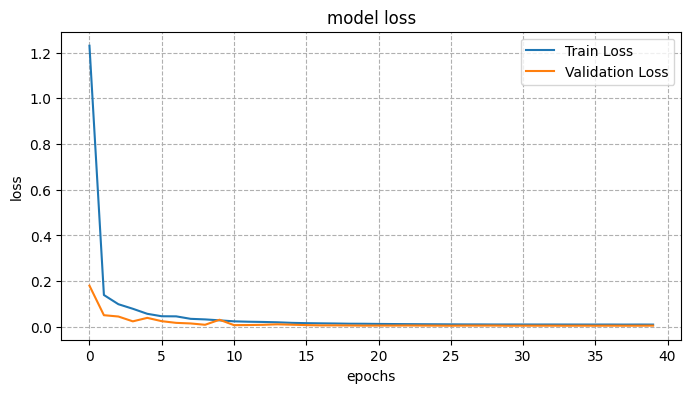

2070/2070 [==============================] - 8s 4ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 7.152
RMSE: 11.003
MAEs:  [ 5.676  7.388  8.655  6.224 11.737  3.231]
RMSEs:  [ 8.011 10.632 12.624  8.665 17.12   4.656]


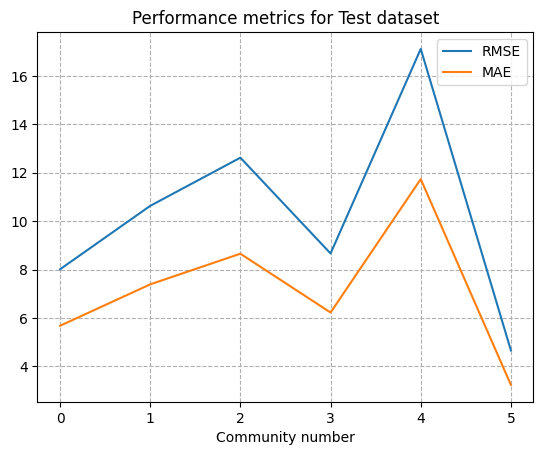

#### Evaluating performance metrics ####

====Train SET ====
MAE: 7.938
RMSE: 12.657
MAEs:  [ 6.497  9.465  7.939  8.568 11.663  3.497]
RMSEs:  [10.159 14.862 11.953 13.677 16.816  4.936]


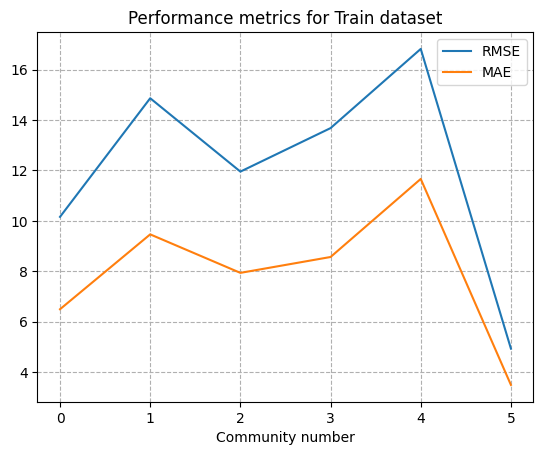

In [12]:
payload = {'Model':one_LSTM,
           'lag' : 96,
           'lstm_size' : 50,
           'dropout' : 0.4,
           'dc_size' : 64,
           'batch_size' : 256,
           'epoch' : 400,
           'patience' : 10,
           'filters': None,
           'only_demand':True,
          }

one_LSTM_model, scaler = model_run(**payload)

Train set starts at 2017-04-15 00:00:00 and ends at 2020-04-15 10:45:00
Validation set starts at 2020-04-15 10:45:00 and ends at 2020-07-15 18:15:00
Test set starts at 2020-07-15 18:15:00 and ends at 2021-05-20 03:15:00

Train set size: 57600
Validation set size: 8736
Test set size: 14973

########################################################
#of timesteps: 96, #of features: 6 and #of output: 6
########################################################

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 96, 6)            24        
 hNormalization)                                                 
                                                                 
 bidirectional (Bidirectiona  (None, 96, 100)          22800     
 l)                                                              
                                                         

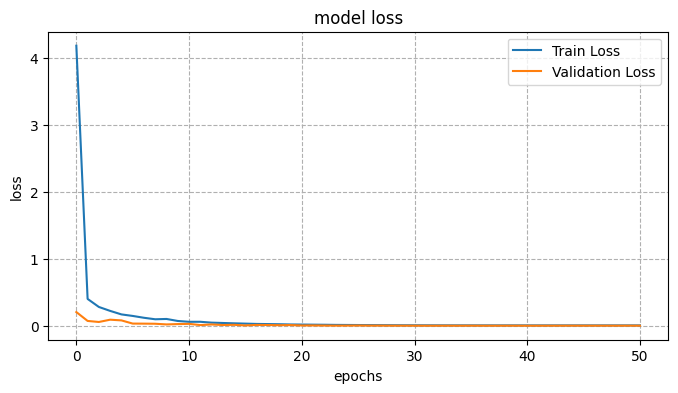

2070/2070 [==============================] - 12s 6ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 7.109
RMSE: 10.702
MAEs:  [ 5.413  7.711  7.877  6.213 12.385  3.053]
RMSEs:  [ 7.771 10.765 11.5    8.633 16.845  4.511]


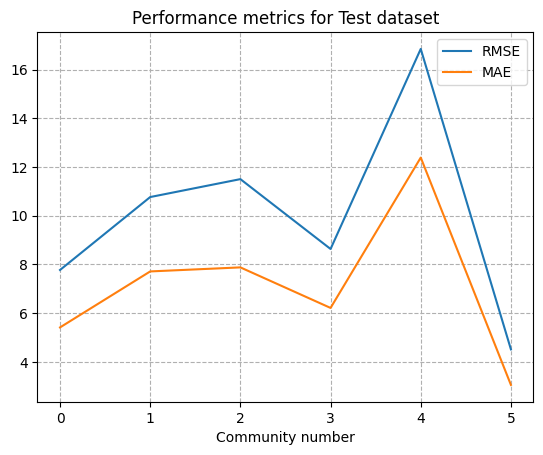

#### Evaluating performance metrics ####

====Train SET ====
MAE: 8.457
RMSE: 14.305
MAEs:  [ 6.476 10.02   8.073  9.328 13.356  3.486]
RMSEs:  [10.401 16.848 12.709 15.521 20.143  5.249]


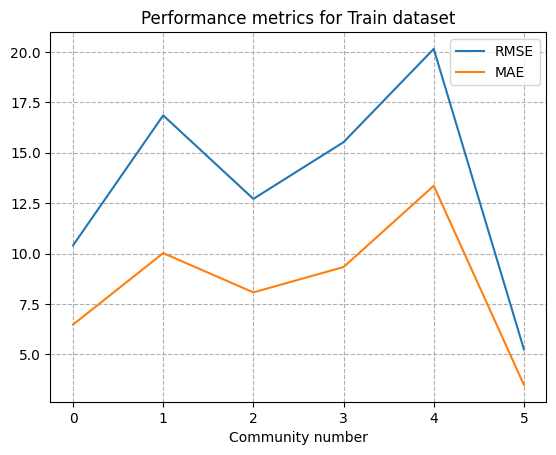

In [13]:
payload = {'Model':one_biLSTM,
           'lag' : 96,
           'lstm_size' : 50,
           'dropout' : 0.4,
           'dc_size' : 64,
           'batch_size' : 256,
           'epoch' : 400,
           'patience' : 10,
           'filters': None,
           'only_demand':True,
          }

one_biLSTM_model, scaler = model_run(**payload)

Train set starts at 2017-04-15 00:00:00 and ends at 2020-04-15 10:45:00
Validation set starts at 2020-04-15 10:45:00 and ends at 2020-07-15 18:15:00
Test set starts at 2020-07-15 18:15:00 and ends at 2021-05-20 03:15:00

Train set size: 57600
Validation set size: 8736
Test set size: 14973

#########################################################################
#of timesteps: 8, #of subsequences: 12, #of features: 6 and #of output: 6
#########################################################################

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 8, 128)     896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 8, 128)     16512     
 tributed)                                                       
  

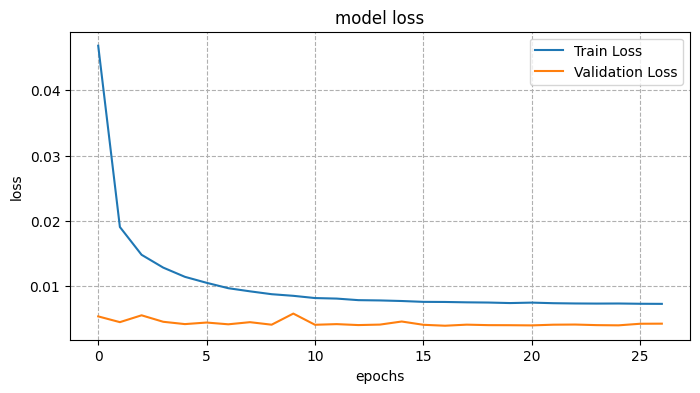

2070/2070 [==============================] - 6s 3ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 5.811
RMSE: 9.124
MAEs:  [4.6   6.034 6.206 5.262 9.987 2.779]
RMSEs:  [ 6.787  9.118  9.46   7.969 14.137  4.173]


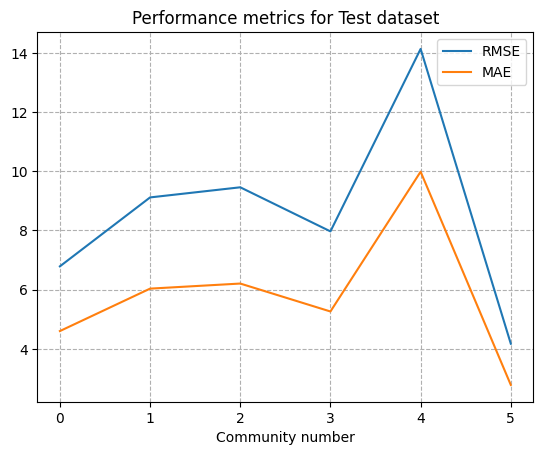

#### Evaluating performance metrics ####

====Train SET ====
MAE: 6.213
RMSE: 9.208
MAEs:  [5.356 6.839 5.994 6.403 9.589 3.094]
RMSEs:  [ 8.005  9.901  8.54   9.315 12.937  4.425]


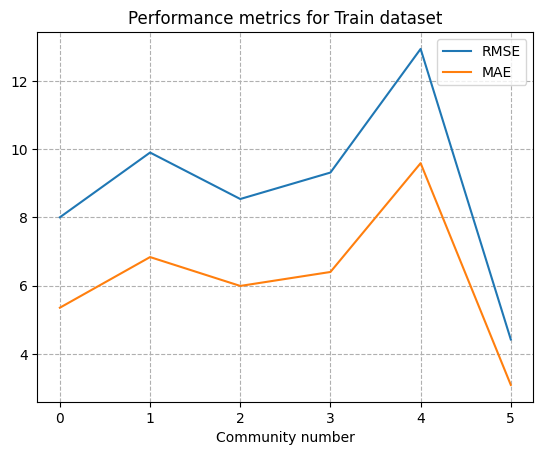

In [14]:
payload = {'Model':TreNet_LSTM,
           'lag' : 96,
           'lstm_size' : 50,
           'dropout' : 0.4,
           'dc_size' : 64,
           'batch_size' : 256,
           'epoch' : 400,
           'patience' : 10,
           'filters': 128,
           'only_demand':True,
          }

TreNet_LSTM_model, scaler = model_run(**payload)

Train set starts at 2017-04-15 00:00:00 and ends at 2020-04-15 10:45:00
Validation set starts at 2020-04-15 10:45:00 and ends at 2020-07-15 18:15:00
Test set starts at 2020-07-15 18:15:00 and ends at 2021-05-20 03:15:00

Train set size: 57600
Validation set size: 8736
Test set size: 14973

#########################################################################
#of timesteps: 8, #of subsequences: 12, #of features: 6 and #of output: 6
#########################################################################

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 8, 128)     896       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 8, 128)     16512     
 tributed)                                                       
  

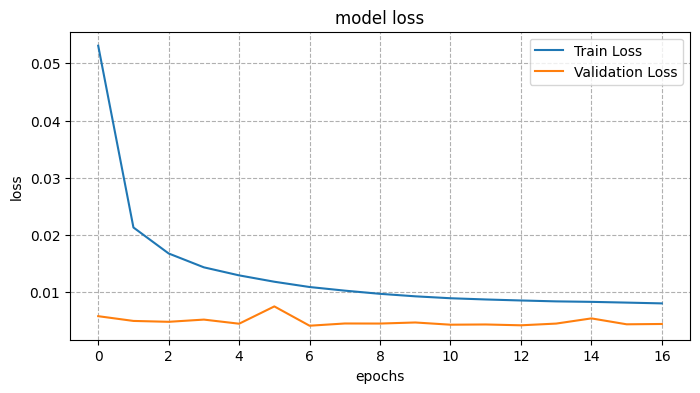

2070/2070 [==============================] - 8s 4ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 6.476
RMSE: 9.653
MAEs:  [ 5.164  6.737  6.208  7.128 10.709  2.91 ]
RMSEs:  [ 7.056  9.916  9.272  9.364 14.842  4.121]


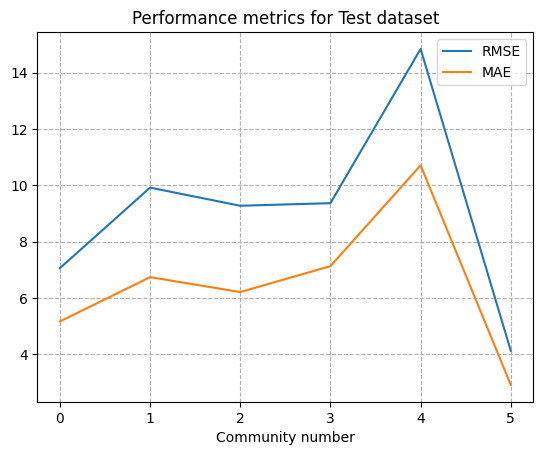

#### Evaluating performance metrics ####

====Train SET ====
MAE: 6.783
RMSE: 9.789
MAEs:  [ 5.778  7.166  6.302  7.832 10.341  3.277]
RMSEs:  [ 8.282 10.281  8.958 10.502 13.779  4.497]


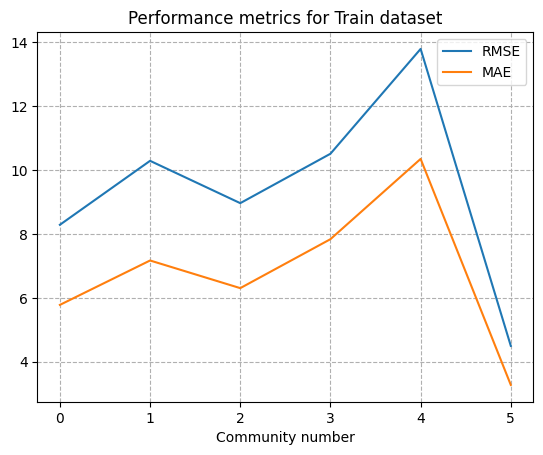

In [15]:
payload = {'Model':TreNet_biLSTM,
           'lag' : 96,
           'lstm_size' : 50,
           'dropout' : 0.4,
           'dc_size' : 64,
           'batch_size' : 256,
           'epoch' : 400,
           'patience' : 10,
           'filters': 128,
           'only_demand':True,
          }

TreNet_biLSTM_model, scaler = model_run(**payload)

### 2) Using bixi demand data, engineered features and weather-calender  - Only `TreNet_LSTM` model

Train set starts at 2017-04-15 00:00:00 and ends at 2020-04-15 10:45:00
Validation set starts at 2020-04-15 10:45:00 and ends at 2020-07-15 18:15:00
Test set starts at 2020-07-15 18:15:00 and ends at 2021-05-20 03:15:00

Train set size: 57600
Validation set size: 8736
Test set size: 14973

#########################################################################
#of timesteps: 5, #of subsequences: 23, #of features: 6 and #of output: 6
#########################################################################

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, None, 5, 128)     896       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 5, 128)     16512     
 tributed)                                                       
  

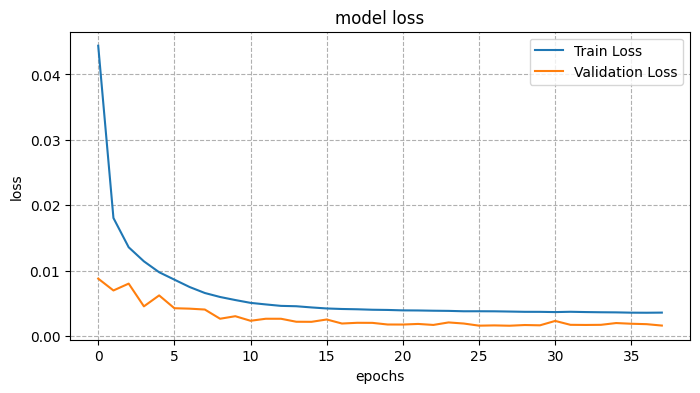

2070/2070 [==============================] - 11s 5ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 3.473
RMSE: 5.462
MAEs:  [3.256 4.471 5.077 4.515 2.698 0.822]
RMSEs:  [4.58  6.694 7.477 6.492 3.742 1.09 ]


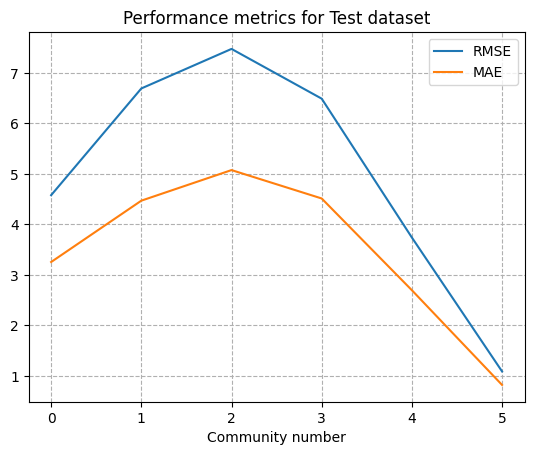

#### Evaluating performance metrics ####

====Train SET ====
MAE: 3.565
RMSE: 5.612
MAEs:  [3.626 4.761 4.698 4.842 2.663 0.803]
RMSEs:  [5.456 6.876 6.643 6.941 4.266 1.179]


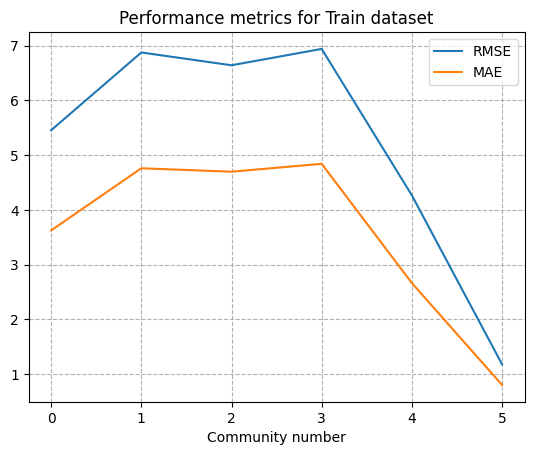

In [16]:
payload = {'Model':TreNet_LSTM,
           'lag' : 96,
           'lstm_size' : 50,
           'dropout' : 0.4,
           'dc_size' : 64,
           'batch_size' : 256,
           'epoch' : 400,
           'patience' : 10,
           'filters': 128,
           'only_demand':False,
          }

TreNet_LSTM_model, scaler_demand, scaler_extra = model_run(**payload)

### 3) ARIMA time series

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import itertools

In [18]:
scaler, X, y = convert_to_supervised(96, bixi_demand)
_, start_test = train_val_test()
X_train, X_test, y_train, y_test = train_test_split(X, y, start_test)

Train set starts at 2017-04-15 00:00:00 and ends at 2020-04-15 10:45:00
Validation set starts at 2020-04-15 10:45:00 and ends at 2020-07-15 18:15:00
Test set starts at 2020-07-15 18:15:00 and ends at 2021-05-20 03:15:00

Train set size: 57600
Validation set size: 8736
Test set size: 14973



In [16]:
%%time
pred_test = np.zeros((y_test.shape))
pred_train = np.zeros((y_train.shape))
for i in range(6):
    # 10 lags and 1 difference
    model = ARIMA(y_train[:,i], order = (10,0,1))
    fitted = model.fit()
    predictions = fitted.forecast(len(y_test), alpha=0.05)
    pred_test[:,i] = predictions
    pred_train[:,i] = fitted.predict()

CPU times: user 11min 49s, sys: 4min 50s, total: 16min 40s
Wall time: 11min 40s


#### Evaluating performance metrics ####

====Test SET ====
MAE: 25.974
RMSE: 32.881
MAEs:  [19.318 28.567 26.764 26.105 46.601  8.491]
RMSEs:  [22.429 32.583 31.569 29.639 54.274 10.064]


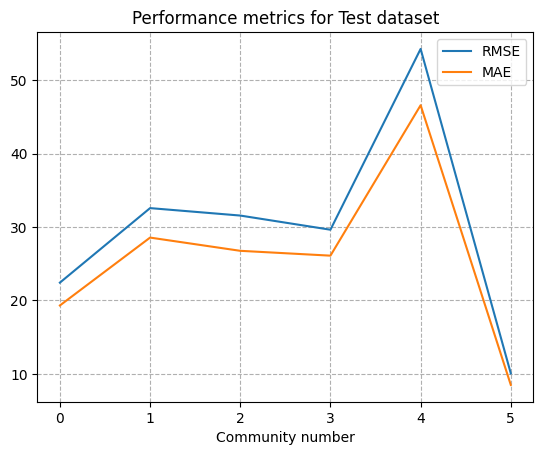

#### Evaluating performance metrics ####

====Train SET ====
MAE: 8.051
RMSE: 12.412
MAEs:  [ 6.893  8.63   7.89   8.677 12.363  3.855]
RMSEs:  [10.113 13.09  11.358 13.199 17.819  5.476]


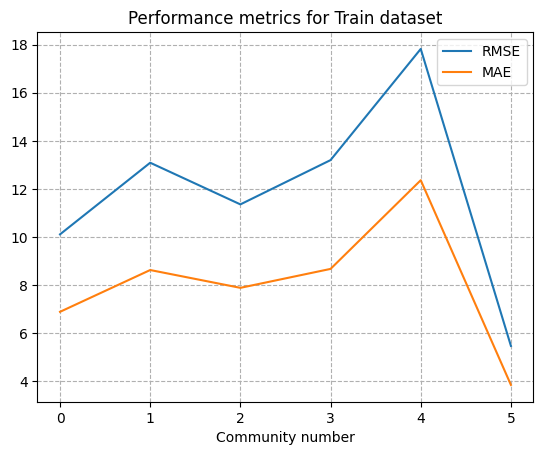

In [20]:
y_true_test = invert_scale(scaler, y_test)
y_hat_test  = invert_scale(scaler, pred_test)

y_true_train = invert_scale(scaler, y_train)
y_hat_train  = invert_scale(scaler, pred_train)

mae_test, MAEs_test, rmse_test, RMSEs_test = evaluate_forecasts(y_true_test, y_hat_test, "Test")
mae_train, MAEs_train, rmse_train, RMSEs_train = evaluate_forecasts(y_true_train, y_hat_train, "Train")